In [2]:
# part 1
import pickle
with open("state_policy.pkl", "rb") as f:
    state_policy = pickle.load(f)
# with open("states.pkl", "rb") as f:
#     states = pickle.load(f)
with open("state_V.pkl", "rb") as f:
    state_V = pickle.load(f)
with open("total_rewards.pkl", "rb") as f:
    total_rewards = pickle.load(f)
with open("action_length.pkl", "rb") as f:
    action_length = pickle.load(f)
with open("visit_time.pkl", "rb") as f:
    visited_time = pickle.load(f)

def round_3x4(matrix):
    # First row (index 0, 1, 2, 3)
    matrix[0][0] = round(matrix[0][0] / 1) * 1  # term1
    matrix[0][2] = round(matrix[0][2] / 1) * 1  # term3
    matrix[0][1] = max(0, min(round(matrix[0][1] / 0.04) * 0.04, 0.04))  # term2 0 ~ 0.12
    matrix[0][3] = round(matrix[0][3] / 1) * 1  # term4
    # Second row (index 1, 2, 3, 4)
    matrix[1][0] = max(-0.05, min(round(matrix[1][0] / 0.01) * 0.01, 0.40))  # term5 -0.05 ~ 0.40
    matrix[1][1] = max(-0.04, min(round(matrix[1][1] / 0.04) * 0.04, 0.04))  # term6 -0.08 ~ 0.08
    matrix[1][2] = max(-0.7, min(round(matrix[1][2] / 0.1) * 0.1, 0.1))  # term7 -0.7 ~ 0.1
    matrix[1][3] = round(matrix[1][3] / 1) * 1  # term8
    # Third row (similar constraints as the second row)
    matrix[2][0] = max(-0.05, min(round(matrix[2][0] / 0.01) * 0.01, 0.40))  # term5 -0.05 ~ 0.40
    matrix[2][1] = max(-0.04, min(round(matrix[2][1] / 0.04) * 0.04, 0.04))  # term6 -0.08 ~ 0.08
    matrix[2][2] = max(-0.7, min(round(matrix[2][2] / 0.1) * 0.1, 0.1))  # term7 -0.7 ~ 0.1
    matrix[2][3] = round(matrix[2][3] / 1) * 1  # term8
    return matrix
        
import numpy as np
from itertools import product
from scipy.spatial import KDTree


term1 = 1
term3 = 1
term2 = np.arange(0, 0.05, 0.04) #2
term2 = np.around(term2, decimals=2)
term4 = 1 

term5 = np.arange(-0.05, 0.41, 0.01) #46
term5 = np.around(term5, decimals=2)
term6 = np.arange(-0.04, 0.05, 0.04) #3
term6 = np.around(term6, decimals=2)
term7 = np.arange(-0.7, 0.19, 0.1) #9
term7 = np.around(term7, decimals=2)
term8 = 1

term9 = np.arange(-0.05, 0.41, 0.01) #46
term9 = np.around(term9, decimals=2)
term10 = np.arange(-0.04, 0.05, 0.04) #5
term10 = np.around(term10, decimals=2)
term11 = np.arange(-0.7, 0.19, 0.1) #9
term11 = np.around(term11, decimals=2)
term12 = 1

combinations = product(term2, term5, term6, term7, term9, term10, term11)

states = [
    np.array([
        [term1, t2, term3, term4],
        [t5, t6, t7, term8],
        [t9, t10, t11, term12]
    ])
    for t2, t5, t6, t7, t9, t10, t11 in combinations
]
print(len(states))
flattened_states = [matrix.flatten() for matrix in states]
kdtree = KDTree(flattened_states)

def find_nearest_kdtree(target_matrix, kdtree, matrix_list):
    target_flat = target_matrix.flatten()
    
    dist, index = kdtree.query(target_flat)
    return index, matrix_list[index]
def find_nearest_kdtree_with_constraints(target_matrix, kdtree, matrix_list):
    target_flat = target_matrix.flatten()
    target_constraints = [target_flat[1], target_flat[5], target_flat[9]]
    filtered_indices = [
        i for i, matrix in enumerate(matrix_list) 
        if abs(matrix.flatten()[1] - target_constraints[0])<0.001 and
           abs(matrix.flatten()[5] - target_constraints[1])<0.001 and
           abs(matrix.flatten()[9] - target_constraints[2])<0.001
    ]
    if not filtered_indices:
        print("can't find",target_matrix)
        return find_nearest_kdtree(target_matrix, kdtree, matrix_list)
    filtered_matrices = [matrix_list[i].flatten() for i in filtered_indices]
    filtered_kdtree = kdtree.__class__(np.array(filtered_matrices))
    dist, filtered_index = filtered_kdtree.query(target_flat)
    original_index = filtered_indices[filtered_index]
    return original_index, matrix_list[original_index]

filtered_states = [states[i] for i in range(len(visited_time)) if visited_time[i] >= 1]
filtered_policy = [state_policy[i] for i in range(len(visited_time)) if visited_time[i] >= 1]
flattened_states1 = [matrix.flatten() for matrix in filtered_states]
kdtree1 = KDTree(flattened_states1)
print(len(filtered_states),len(filtered_policy))

3085128


In [4]:
# part 2
import gymnasium as gym
import highway_env
import numpy as np
import random
# Create the environment
config = {
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "lanes_count": 2,
        "vehicles_count": 3
    },
        "order": "sorted",
        "lanes_count": 2,
        "vehicles_count": 25,
        "absolute": False
}
env = gym.make('highway-fast-v0', config=config)

In [5]:
testlength = []
testreward = []
percentage_30 = 0
newin=0
for q in range (10000):
    test_action_length = 0
    rewardtest = 0
    done = False
    state, _ = env.reset()
    while not done:
        s1 = round_3x4(state)
        c1, c2 = find_nearest_kdtree_with_constraints(s1, kdtree1, filtered_states)
        # if visited_time[c1]<=1 and test_action_length == 0:
        #     newin+=1
        #     print(q, "n")
        action = filtered_policy[c1]
        n_state, reward, done, additional_info, info = env.step(action)
        test_action_length += 1
        # print(q, action, reward, c2)
        a = n_state
        rewardtest += reward
        # time.sleep(1)
        state = n_state
        if additional_info:
            done = True
    testlength.append(test_action_length)
    testreward.append(rewardtest)
percentage_30 = sum(1 for length in testlength if length >= 30) / 10000 * 100
average_reward = sum(testreward) / 10000

print(f"Success Rate: {round(percentage_30,1)}%")
print(f"Average reward: {average_reward}")
# print(newin)

Success Rate: 20.2%
Average reward: 13.320307234562105
0


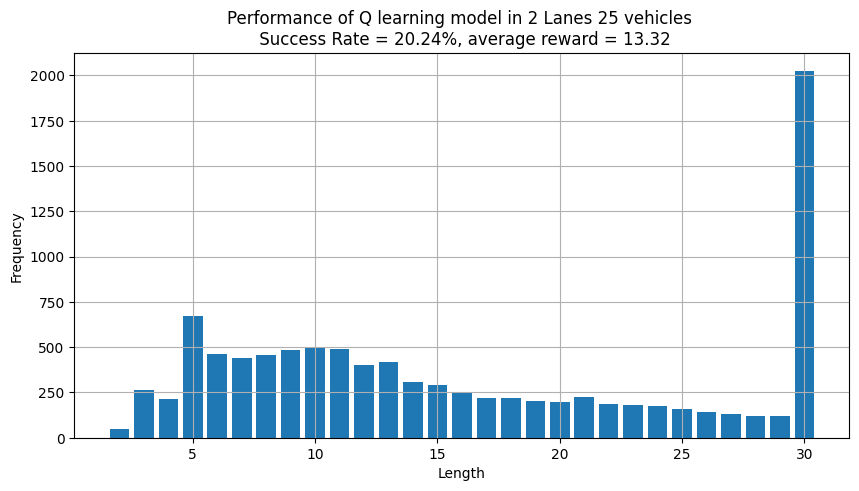

In [38]:
import matplotlib.pyplot as plt
from collections import Counter
plt.figure(figsize=(10, 5))
frequency = Counter(testlength)
values = sorted(frequency.keys())
counts = [frequency[val] for val in values] 
plt.bar(values, counts)
plt.title(f"Performance of Q learning model in 2 Lanes 25 vehicles \n Success Rate = {round(percentage_30,2)}%, average reward = {round(average_reward,2)}")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [30]:
# part 3
import gymnasium as gym
import highway_env
import numpy as np
import random
# Create the environment
config = {
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "lanes_count": 2,
        "vehicles_count": 3
    },
        "order": "sorted",
        "lanes_count": 2,
        "vehicles_count": 50,
        "absolute": False
}
env = gym.make('highway-fast-v0', config=config)

In [31]:
testlength_50 = []
testreward_50 = []
percentage_30_50 = 0
for q in range (10000):
    test_action_length_50 = 0
    rewardtest_50 = 0
    done = False
    state, _ = env.reset()
    while not done:
        s1 = round_3x4(state)
        c1, c2 = find_nearest_kdtree_with_constraints(s1, kdtree1, filtered_states)
        # if visited_time[c1]<=1 and test_action_length == 0:
        #     newin+=1
        #     print(q, "n")
        action = filtered_policy[c1]
        n_state, reward, done, additional_info, info = env.step(action)
        test_action_length_50 += 1
        # print(q, action, reward, c2)
        a = n_state
        rewardtest_50 += reward
        # time.sleep(1)
        state = n_state
        if additional_info:
            done = True
    testlength_50.append(test_action_length_50)
    testreward_50.append(rewardtest_50)
percentage_30_50 = sum(1 for length in testlength_50 if length >= 30) / 10000 * 100
average_reward_50 = sum(testreward_50) / 10000

print(f"Success Rate: {round(percentage_30_50,1)}%")
print(f"Average reward: {average_reward_50}")

Success Rate: 21.0%
Average reward: 13.534416008349886


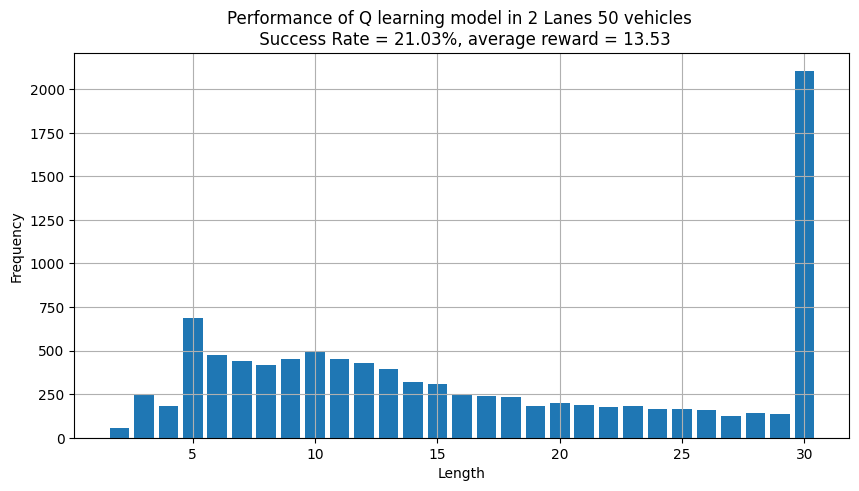

In [40]:
import matplotlib.pyplot as plt
from collections import Counter
plt.figure(figsize=(10, 5))
frequency = Counter(testlength_50)
values = sorted(frequency.keys())
counts = [frequency[val] for val in values] 
plt.bar(values, counts)
plt.title(f"Performance of Q learning model in 2 Lanes 50 vehicles \n Success Rate = {round(percentage_30_50,2)}%, average reward = {round(average_reward_50,2)}")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [35]:
# part 4
import gymnasium as gym
import highway_env
import numpy as np
import random
# Create the environment
config = {
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20]
        },
        "absolute": False,
        "lanes_count": 2,
        "vehicles_count": 3
    },
        "order": "sorted",
        "lanes_count": 2,
        "vehicles_count": 100,
        "absolute": False
}
env = gym.make('highway-fast-v0', config=config)

In [36]:
testlength_100 = []
testreward_100 = []
percentage_30_100 = 0
for q in range (10000):
    test_action_length_100 = 0
    rewardtest_100 = 0
    done = False
    state, _ = env.reset()
    while not done:
        s1 = round_3x4(state)
        c1, c2 = find_nearest_kdtree_with_constraints(s1, kdtree1, filtered_states)
        # if visited_time[c1]<=1 and test_action_length == 0:
        #     newin+=1
        #     print(q, "n")
        action = filtered_policy[c1]
        n_state, reward, done, additional_info, info = env.step(action)
        test_action_length_100 += 1
        # print(q, action, reward, c2)
        a = n_state
        rewardtest_100 += reward
        # time.sleep(1)
        state = n_state
        if additional_info:
            done = True
    testlength_100.append(test_action_length_100)
    testreward_100.append(rewardtest_100)
percentage_30_100 = sum(1 for length in testlength_100 if length >= 30) / 10000 * 100
average_reward_100 = sum(testreward_100) / 10000

print(f"Success Rate: {round(percentage_30_100,1)}%")
print(f"Average reward: {average_reward_100}")

Success Rate: 21.2%
Average reward: 13.418853550982377


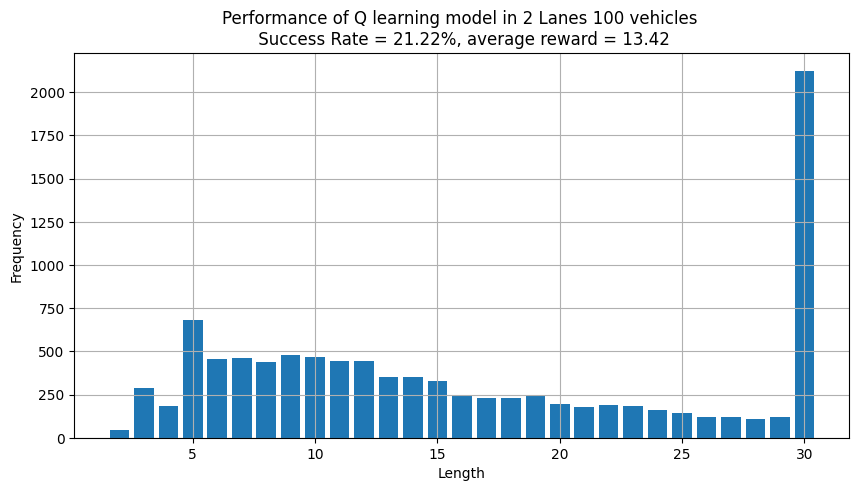

In [39]:
import matplotlib.pyplot as plt
from collections import Counter
plt.figure(figsize=(10, 5))
frequency = Counter(testlength_100)
values = sorted(frequency.keys())
counts = [frequency[val] for val in values] 
plt.bar(values, counts)
plt.title(f"Performance of Q learning model in 2 Lanes 100 vehicles \n Success Rate = {round(percentage_30_100,2)}%, average reward = {round(average_reward_100,2)}")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid()
plt.show()